In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm


from fibrosisanalysis.parsers import ImageLoader


path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')

hearts = ['E10691_RBM20', 'E11444_LMNA', 'E10927_MYBPC3']


data = []

for heart in hearts[:]:
    slice_names = Path(path.joinpath(heart, 'Stats')).glob('*')
    slice_names = sorted([f.stem for f in slice_names if f.suffix == '.pkl'])

    density_or = []
    density_ds = []
    density_gen = []

    for slice_name in tqdm(slice_names[:]):
        image_loader = ImageLoader()
        image_or = image_loader.load_slice_data(path.joinpath(heart, 'Images',
                                                              slice_name))
        density_or.append(np.sum(image_or == 2) / np.sum(image_or > 0))

        image_ds = image_loader.load_slice_data(path.joinpath(heart, 'DS',
                                                              slice_name))
        image_ds[image_or == 0] = 0
        density_ds.append(np.sum(image_ds == 2) / np.sum(image_ds > 0))

        image_gen = image_loader.load_slice_data(path.joinpath(heart, 'Generated',
                                                               slice_name.replace('NABL', 'WABL')))
        density_gen.append(np.sum(image_gen == 2) / np.sum(image_gen > 0))

    df = pd.DataFrame({'Histological': np.array(density_or),
                       'Direct Sampling': np.array(density_ds),
                       'Uniform Generator': np.array(density_gen),
                       'Slice Index': np.arange(len(slice_names)),
                       'Heart': np.repeat(heart, len(slice_names))})
    data.append(df)

data = pd.concat(data)

100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


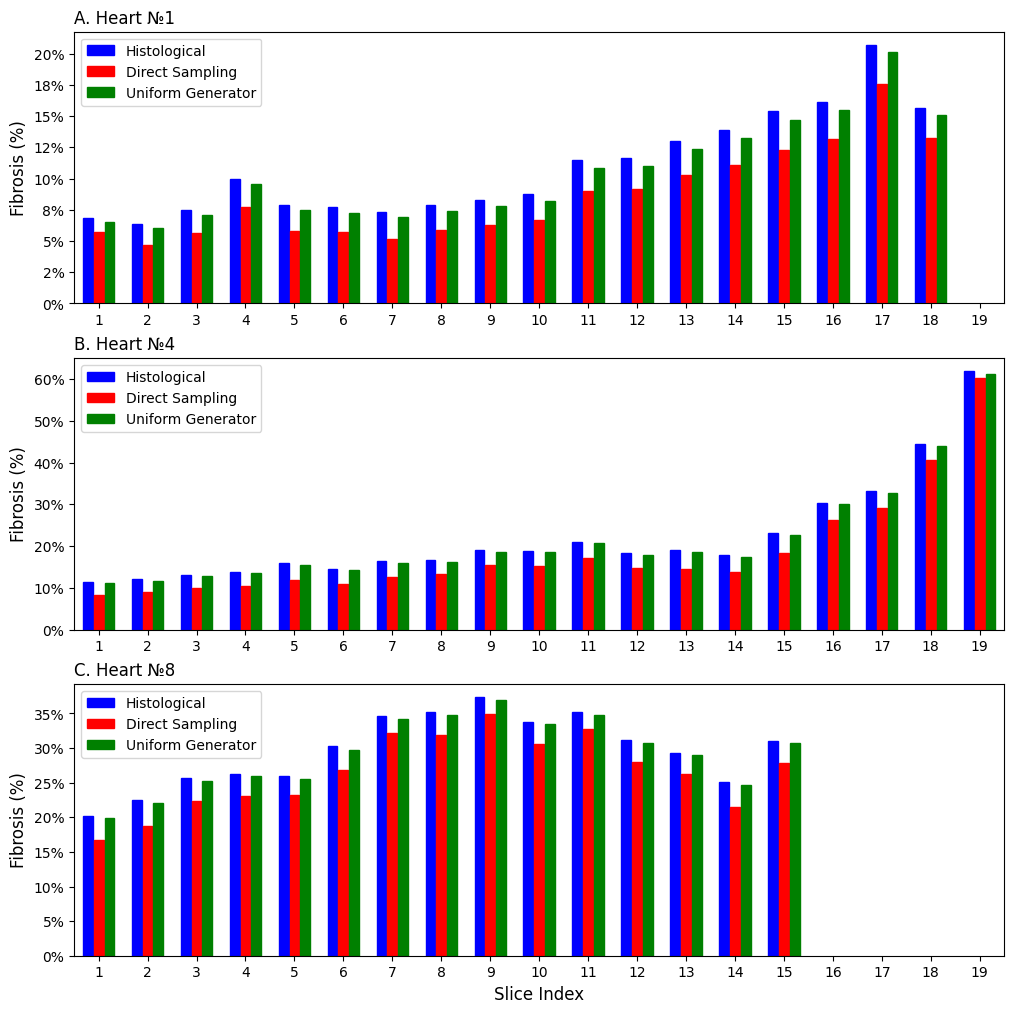

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

titles = ['A. Heart №1', 'B. Heart №4', 'C. Heart №8']
fig, axs = plt.subplots(nrows=3, figsize=(12, 12), sharex=False, sharey=False)

for i, heart in enumerate(hearts[:]):
    df = data[data['Heart'] == heart]
    ax = axs[i]
    ax.bar(df['Slice Index'] + 0.78, df['Histological'], width=0.2,
               facecolor='blue', edgecolor='blue')
    ax.bar(df['Slice Index'] + 1, df['Direct Sampling'], width=0.2,
               facecolor='red', edgecolor='red')
    ax.bar(df['Slice Index'] + 1.22, df['Uniform Generator'], width=0.2,
               facecolor='green', edgecolor='green')
    
    ax.set_title(titles[i], loc='left')
    ax.set_ylabel('Fibrosis (%)', fontsize=12)
    ax.legend(['Histological', 'Direct Sampling', 'Uniform Generator'],
                  loc='upper left', fontsize=10)
    ax.set_xticks(np.arange(1, 20, 1))
    # ax.grid(axis='x')
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
    ax.set_xlim(0.5, 19.5)
axs[-1].set_xlabel('Slice Index', fontsize=12)
plt.show()

In [6]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('density_per_slice.png'), dpi=300)

In [10]:

for heart in hearts:
    df = data[data['Heart'] == heart]
    err_ds = df['Histological'].values - df['Direct Sampling'].values
    err_gen = df['Histological'].values - df['Uniform Generator'].values

    print(heart)
    print(100 * np.mean(err_ds), 100 * np.std(err_ds))
    print(100 * np.mean(err_gen), 100 * np.std(err_gen))

E10691_RBM20
2.3051069205553825 0.5033025942243147
0.5302162796194552 0.10259213844613747
E11444_LMNA
3.626353509183864 0.6217678647575492
0.38579288837821274 0.09152846960425921
E10927_MYBPC3
3.141958896322462 0.407098804628272
0.4033135227200885 0.05512226831997912
